In [2]:
import pandas as pd
import numpy as np
import sympy as sp
import math as m
from sympy import collect, simplify, expand, fraction, latex, diff, cancel, nsimplify
from IPython.display import display, Markdown, Math
import matplotlib.pyplot as plt

In [20]:
def theta_hat_ploter(df, theta0, title, line_width=1.2):
    lst_color = ['b', 'y', 'g', 'r']
    lst_labels = df.columns
    graph = sns.lineplot(data=df, dashes=False)

    for i in range(len(theta0)):
        graph.axhline(y=theta0[i], color=lst_color[i], linestyle='--', linewidth=line_width, label=lst_labels[i])
        
    plt.title(title, fontsize=20)
    plt.ylabel('Magnitude of "Theta_hat"', fontsize=18)
    plt.xlabel('Time Stamps "t"', fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 1), 
               loc=2, 
               borderaxespad=0, 
               labels=lst_labels, 
               fontsize='xx-large')
    plt.show()

# Problem 1

## Part 1

In [2]:
a, b, p = sp.symbols("a b p")
zeta, omega, theta1, theta2 = sp.symbols("zeta omega theta_1 theta_2")
y, u, uc, ym = sp.symbols("y(t) u(t) u_{c}(t) y_m")

y_eq = sp.solve(sp.Eq(y*p**2, (-a*p*y + b*u)), y)[0]

u_eq = sp.solve(sp.Eq(u, (theta1*(y - uc) - theta2*p*y)), u)[0]
y_eq = sp.solve(sp.Eq(y, y_eq.subs(u, u_eq)), y)[0]
display(Math("y = "+latex(y_eq)))

<IPython.core.display.Math object>

In [3]:
bm0, am1, am0 = sp.symbols("b_{m0} a_{m1} a_{m0}")

b_m0 = omega**2
a_m1 = 2*zeta*omega
a_m0 = b_m0

# Bm = bm0
# Am = (p**2 + am1*p + bm0)

Bm = omega**2
Am = (p**2 + 2*zeta*omega*p + omega**2)

Gm = Bm/Am
Gm
display(Math("G_{m} = "+latex(Gm)))

<IPython.core.display.Math object>

In [4]:
num, den = fraction(y_eq)
num_m, den_m = fraction(Gm*uc)

theta_1 = sp.solve(sp.Eq(num, num_m), theta1)[0]
theta_2 = sp.solve(sp.Eq(den.subs(theta1, theta_1), den_m), theta2)[0]

display(Math("\\theta_1 =\;"+latex(theta_1)))
display(Math("\\theta_2 =\;"+latex(theta_2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
del_e_theta1 = collect(simplify(diff(y_eq, theta1)), p)
del_e_theta2 = collect(simplify(diff(y_eq, theta2)), p)

del_e_theta1_fact = simplify(cancel(del_e_theta1/y_eq)*y)
num_theta1, den_theta1 = fraction(del_e_theta1_fact)

del_e_theta2_fact = simplify(cancel(del_e_theta2/y_eq)*y)
num_theta2, den_theta2 = fraction(del_e_theta2_fact)

display(Math("\\frac{\\partial e}{\\partial \\theta_1} =\;"
             +latex(del_e_theta1)+"\;=\;"
             +latex(del_e_theta1_fact.subs([(theta1, theta_1), (theta2, theta_2)]))+"\;=\;"
             +latex(num_theta1.subs(theta2,theta_2)/(Am*theta_1))))

display(Math("\\frac{\\partial e}{\\partial \\theta_2} =\;"
             +latex(del_e_theta2)+"\;=\;"
             +latex(del_e_theta2_fact.subs([(theta1, theta_1), (theta2, theta_2)]))+"\;=\;"
             +latex(num_theta2/Am)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
display(simplify(cancel(del_e_theta1/y_eq)))
display(simplify(cancel(del_e_theta2/y_eq)))

p*(a + b*theta_2 + p)/(theta_1*(a*p + b*p*theta_2 - b*theta_1 + p**2))

-b*p/(a*p + b*p*theta_2 - b*theta_1 + p**2)

# Problem 2

## Part 1

In [7]:
y, u, uc, ym, e = sp.symbols("y(t) u(t) u_{c}(t) y_m e")
alpha, beta, gamma, b, theta1, theta2, p = sp.symbols("alpha beta gamma b theta_1 theta_2 p")

V1 = 0.5*e**2
V2 = 1/(b*gamma*2)*(alpha - b*theta2)**2
V3 = 1/(b*gamma*2)*(beta - b*theta1)**2
V = V1 + V2 + V3

y_eq = b*u/p
u_eq = theta1*uc - theta2*y

y_eq = sp.solve(sp.Eq(y,y_eq.subs(u, u_eq)),y)[0]
display(Math("y = "+latex(y_eq)))

<IPython.core.display.Math object>

In [8]:
Bm = beta
Am = p + alpha

Gm = Bm/Am

ym_eq = sp.solve(sp.Eq(ym,Gm*uc), ym)[0]
display(Math("y_{m} = "+latex(ym_eq)))

<IPython.core.display.Math object>

In [9]:
num, den = fraction(y_eq)
num_m, den_m = fraction(ym_eq)

theta_1 = sp.solve(sp.Eq(num, num_m), theta1)[0]
theta_2 = sp.solve(sp.Eq(den, den_m), theta2)[0]

display(Math("\\theta_1 =\;"+latex(theta_1)))
display(Math("\\theta_2 =\;"+latex(theta_2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
y, u, uc, ym = sp.symbols("y(t) u(t) u_{c}(t) y_m")
alpha, beta, b, theta1, theta2, p = sp.symbols("alpha beta b theta_1 theta_2 p")

y_dot = b*u_eq
ym_dot = -alpha*ym + beta*uc
e_dot = collect(expand(y_dot - ym_dot), y)
e_dot_poly = sp.Poly(e_dot, [y,uc])
e_dot_poly_subd = e_dot_poly.as_expr().subs([(theta1, theta_1), (theta2, theta_2)])

e_dot_alt = uc*(b*theta1 - beta) - b*theta2*y - e + alpha*y
e_dot_alt_poly = sp.Poly(e_dot_alt, [e, theta1, theta2])


V_subd = V.subs([(e,0), (theta1, theta_1), (theta2, theta_2)])

display(Math("\\dot{y} =\;"+latex(y_dot)))
display(Math("\\dot{y}_m =\;"+latex(ym_dot)))
display(Math("\\dot{e} =\;"+latex(e_dot_poly.as_expr())+"\;=\;"+
            latex(e_dot_alt_poly.as_expr())))
# display(e_dot_alt_poly.coeffs()[3])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

alpha*y(t) - beta*u_{c}(t)

Subing in $\theta_1$ and $\theta_2$ into $\dot{e}$ gives {{e_dot_poly_subd}}, therefore, if $\theta_1$ and $\theta_2$ converge to their true values, then $y$ must converge to $y_m$

Subing these results into the equation provided in the assingment document gives

$V(e) =\;$ {{V}} $\;=\;$ {{V_subd}}

Therefore, the first condition for the lyapunov function is satisfied (i.e. V = 0 at the equilibrium point)

In [11]:
eDot, theta1Dot, theta2Dot = sp.symbols("\\dot{e} \\dot{\\theta}_1 \\dot{\\theta}_2")

V_dot = nsimplify(diff(V1, e))*eDot+ diff(V2,theta2)*theta2Dot + diff(V3,theta1)*theta1Dot
V_dot_subd = V_dot.subs([(eDot, e_dot_alt)])
V_dot_subd_alt = V_dot.subs([(eDot, e_dot_alt), (theta1, theta_1), (theta2, theta_2)])
V_dot_subd_poly = sp.Poly(V_dot_subd, [theta1Dot, theta2Dot, y, uc])

display(Math("\\dot{V}(e) =\;"+latex(V_dot)))
display(Math("\\dot{V}(e) =\;"+latex(V_dot_subd_poly.as_expr())))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Subbing the true values for  $\theta_1$ and $\theta_2$ into $\dot{V}(e)$ gives

$\dot{V}(e)=\;${{V_dot_subd_alt}}

Which means that $\dot{V}(e)$ is decreasing thus satisfying Lyanupov's second criteria. 

## Derivation of Control Parameters

In [12]:
lst_coeffs = V_dot_subd_poly.coeffs()
equ_1 = lst_coeffs[0]*theta1Dot + lst_coeffs[3]*uc
equ_2 = lst_coeffs[1]*theta2Dot + lst_coeffs[2]*y


theta1_dot = sp.solve(sp.Eq(equ_1, 0), theta1Dot)[0]
theta2_dot = sp.solve(sp.Eq(equ_2, 0), theta2Dot)[0]

# display(Math("\\dot{\\theta}_1 =\;"+latex(theta1_dot)))
# display(Math("\\dot{\\theta}_2 =\;"+latex(theta2_dot)))

The equations for updating the control parameters can be obtained from

{{equ_1}}$\;=0$ 

$\Rightarrow \; \dot{\theta}_1 = \;${{theta1_dot}}

and 

{{equ_2}}$\;=0$ 

$\Rightarrow \; \dot{\theta}_2 = \;${{theta2_dot}}

## Part 2

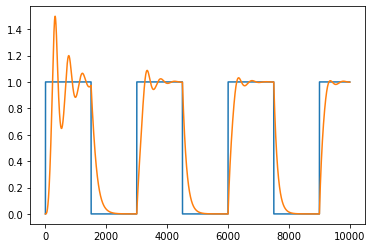

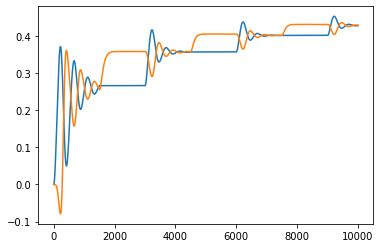

In [42]:
T = 0.01
sample_depth = int(100/T) # 1000 samples totalling 100 seconds (since sample time T is 0.1 secons)
sample_range = range(sample_depth)

t = [i for i in sample_range]
uc = np.ones(sample_depth)
uc[np.where([m.sin(t[i]*m.pi*T/15)<=0 for i in sample_range])] = 0

# actual parameters
b = 2
beta = 1
alpha = 1
gamma = 0.5

y = [0]
ym = [0]
u = [0]
e = 0

theta_1 = [0]
theta_2 = [0]

for i in range(sample_depth):
    theta_1.append(theta_1[i] - T*e*gamma*uc[i])
    theta_2.append(theta_2[i] + T*e*gamma*y[i])
    
    y.append(y[i] + T*b*(theta_1[-1]*uc[i] - theta_2[-1]*y[i]))
    ym.append(ym[i] + T*(-alpha*ym[i] + beta*uc[i]))
    
    e = y[i] - ym[i]
y.pop(-1)
theta_1.pop(-1)
theta_2.pop(-1)

plt.plot(t,uc)
plt.plot(t,y)
plt.show()

plt.plot(t, theta_1)
plt.plot(t, theta_2)
    